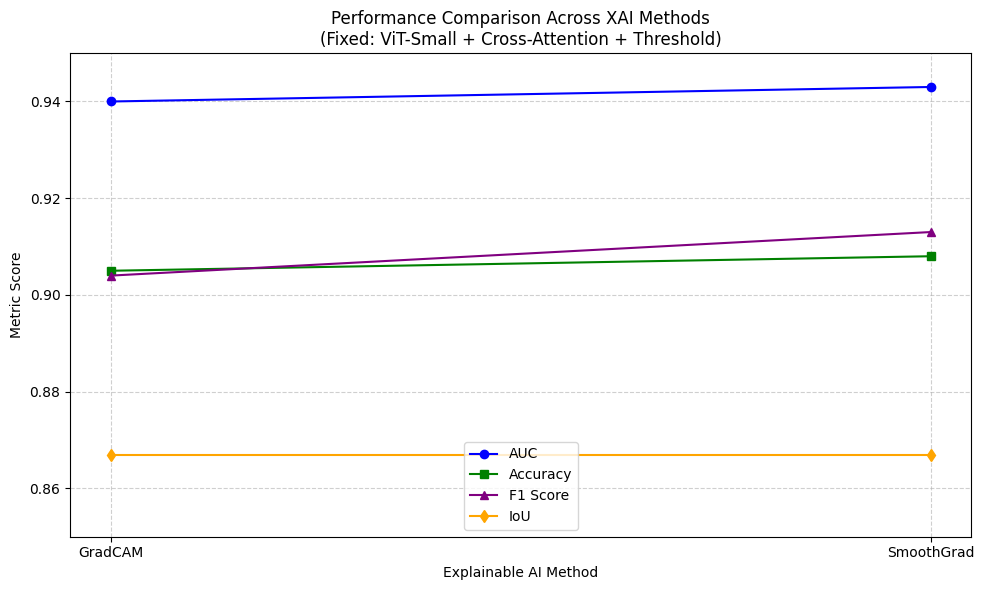

In [ ]:
import matplotlib.pyplot as plt

# Sample Data
xai_methods = ["GradCAM", "SmoothGrad"]
auc_scores = [0.940, 0.943]
accuracy_scores = [0.905, 0.908]
f1_scores = [0.904, 0.913]
iou_scores = [0.867, 0.867]

plt.figure(figsize=(10, 6))

# Plotting each metric as a line
plt.plot(xai_methods, auc_scores, marker='o', label='AUC', color='blue')
plt.plot(xai_methods, accuracy_scores, marker='s', label='Accuracy', color='green')
plt.plot(xai_methods, f1_scores, marker='^', label='F1 Score', color='purple')
plt.plot(xai_methods, iou_scores, marker='d', label='IoU', color='orange')

# Formatting
plt.xlabel("Explainable AI Method")
plt.ylabel("Metric Score")
plt.title("Performance Comparison Across XAI Methods\n(Fixed: ViT-Small + Cross-Attention + Threshold)")
plt.ylim(0.85, 0.95)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


**MODEL ARCHITECTURE AND SOME DEFINITION OF SOME FUNCTIONS**

---



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Conv2D, BatchNormalization, ReLU, UpSampling2D,
                                    GlobalAveragePooling2D, Dense, Dropout, Concatenate,
                                    Resizing, Multiply, Activation)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

# Define constants
IMG_H, IMG_W = 352, 352
FILTERS = 32
NUM_CLASSES = 2

# Class weights
seg_class_weights = tf.constant([10.0, 10.0], dtype=tf.float32)
cls_class_weights = tf.constant([1.0, 5.0, 8.0, 10.0], dtype=tf.float32)

# Load pre-trained ResNet50 backbone
backbone = ResNet50(include_top=False, input_shape=(IMG_H, IMG_W, 3))
backbone.trainable = True

# Feature extraction layers
feature_layers = [
    'conv2_block3_out',  # Level 2
    'conv3_block4_out',  # Level 3
    'conv4_block6_out',  # Level 4
    'conv5_block3_out',  # Level 5
]
feature_extractor = tf.keras.Model(
    inputs=backbone.input,
    outputs=[backbone.get_layer(layer).output for layer in feature_layers],
    name="feature_extractor"
)

# Receptive Field Block (RFB) with named layers
def RFB(inputs, filters, name):
    branch1 = Conv2D(filters, (1, 1), padding='same', name=f"{name}_branch1")(inputs)

    branch2 = Conv2D(filters, (1, 1), padding='same', name=f"{name}_branch2a")(inputs)
    branch2 = Conv2D(filters, (1, 3), padding='same', name=f"{name}_branch2b")(branch2)
    branch2 = Conv2D(filters, (3, 1), padding='same', name=f"{name}_branch2c")(branch2)
    branch2 = Conv2D(filters, (3, 3), padding='same', dilation_rate=(3, 3), name=f"{name}_branch2d")(branch2)

    branch3 = Conv2D(filters, (1, 1), padding='same', name=f"{name}_branch3a")(inputs)
    branch3 = Conv2D(filters, (1, 5), padding='same', name=f"{name}_branch3b")(branch3)
    branch3 = Conv2D(filters, (5, 1), padding='same', name=f"{name}_branch3c")(branch3)
    branch3 = Conv2D(filters, (3, 3), padding='same', dilation_rate=(5, 5), name=f"{name}_branch3d")(branch3)

    branch4 = Conv2D(filters, (1, 1), padding='same', name=f"{name}_branch4a")(inputs)
    branch4 = Conv2D(filters, (1, 7), padding='same', name=f"{name}_branch4b")(branch4)
    branch4 = Conv2D(filters, (7, 1), padding='same', name=f"{name}_branch4c")(branch4)
    branch4 = Conv2D(filters, (3, 3), padding='same', dilation_rate=(7, 7), name=f"{name}_branch4d")(branch4)

    concat = Concatenate(axis=-1, name=f"{name}_concat")([branch1, branch2, branch3, branch4])
    concat = Conv2D(filters, (1, 1), padding='same', name=f"{name}_concat_conv")(concat)
    shortcut = Conv2D(filters, (1, 1), padding='same', name=f"{name}_shortcut")(inputs)
    output = ReLU(name=f"{name}_output")(concat + shortcut)
    return output

# Partial Decoder with named layers
def PartialDecoder(feat1, feat2, feat3, filters, name="partial_decoder"):
    up1 = UpSampling2D(size=(2, 2), interpolation='bilinear', name=f"{name}_up1")(feat1)
    up1 = Conv2D(filters, (3, 3), padding='same', name=f"{name}_conv1")(up1)

    up2 = UpSampling2D(size=(2, 2), interpolation='bilinear', name=f"{name}_up2")(feat2)
    up2 = Conv2D(filters, (3, 3), padding='same', name=f"{name}_conv2")(up2)

    up1 = Resizing(feat3.shape[1], feat3.shape[2], name=f"{name}_resize1")(up1)
    up2 = Resizing(feat3.shape[1], feat3.shape[2], name=f"{name}_resize2")(up2)

    concat = Concatenate(axis=-1, name=f"{name}_concat")([feat3, up1, up2])
    concat = Conv2D(filters * 2, (3, 3), padding='same', name=f"{name}_concat_conv")(concat)
    output = Conv2D(1, (1, 1), padding='same', name=f"{name}_output")(concat)
    return output

# Reverse Attention with named layers

# class ReverseAttention(tf.keras.layers.Layer):

#     def _init_(self, filters, kernel_size=(3, 3), branch='gsmap', name=None, **kwargs):
#         super(ReverseAttention, self)._init_(name=name, **kwargs)
#         self.filters = filters
#         self.kernel_size = kernel_size
#         self.branch = branch
#         self.conv_layers = []

#         if self.branch == 'gsmap':
#             self.conv_layers = [
#                 Conv2D(filters, (1, 1), padding='same', name=f"{name}_conv1"),
#                 Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv2"),
#                 ReLU(name=f"{name}_relu1"),
#                 Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv3"),
#                 ReLU(name=f"{name}_relu2"),
#                 Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv4"),
#                 ReLU(name=f"{name}_relu3"),
#                 Conv2D(1, (1, 1), padding='same', name=f"{name}_output")
#             ]
#         else:
#             self.conv_layers = [
#                 Conv2D(filters, (1, 1), padding='same', name=f"{name}_conv1"),
#                 Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv2"),
#                 ReLU(name=f"{name}_relu1"),
#                 Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv3"),
#                 ReLU(name=f"{name}_relu2"),
#                 Conv2D(1, kernel_size, padding='same', name=f"{name}_output")
#             ]

#     def call(self, side_feat, saliency_map):
#         x = Activation('sigmoid', name=f"{self.name}_sigmoid")(saliency_map)
#         x = Multiply(name=f"{self.name}_multiply")([1.0 - x, side_feat])
#         for layer in self.conv_layers:
#             x = layer(x)
#         return x + saliency_map



class ReverseAttention(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=(3, 3), branch='gsmap', name=None, **kwargs): # Added filters, kernel_size, and branch as parameters
        super(ReverseAttention, self).__init__(name=name, **kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.branch = branch
        self.conv_layers = []

        if self.branch == 'gsmap':
            self.conv_layers = [
                Conv2D(filters, (1, 1), padding='same', name=f"{name}_conv1"),
                Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv2"),
                ReLU(name=f"{name}_relu1"),
                Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv3"),
                ReLU(name=f"{name}_relu2"),
                Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv4"),
                ReLU(name=f"{name}_relu3"),
                Conv2D(1, (1, 1), padding='same', name=f"{name}_output")
            ]
        else:
            self.conv_layers = [
                Conv2D(filters, (1, 1), padding='same', name=f"{name}_conv1"),
                Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv2"),
                ReLU(name=f"{name}_relu1"),
                Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv3"),
                ReLU(name=f"{name}_relu2"),
                Conv2D(1, kernel_size, padding='same', name=f"{name}_output")
            ]

    def call(self, side_feat, saliency_map):
        x = Activation('sigmoid', name=f"{self.name}_sigmoid")(saliency_map)
        x = Multiply(name=f"{self.name}_multiply")([1.0 - x, side_feat])
        for layer in self.conv_layers:
            x = layer(x)
        return x + saliency_map

def build_waternet(input_shape):
    inputs = tf.keras.Input(shape=input_shape, name="input")
    features = feature_extractor(inputs)

    # RFB with named layers
    feat2_rfb = RFB(features[1], FILTERS, name="rfb_2")
    feat3_rfb = RFB(features[2], FILTERS, name="rfb_3")
    feat4_rfb = RFB(features[3], FILTERS, name="rfb_4")

    # Partial Decoder with named layers
    sg = PartialDecoder(feat4_rfb, feat3_rfb, feat2_rfb, FILTERS)
    sg = Resizing(IMG_H, IMG_W, name="pd_resize")(sg)

    # Reverse Attention with named layers

    ra_4 = ReverseAttention(filters=256, kernel_size=(5, 5), branch='gsmap', name="ra_4")

    s4 = ra_4(features[3], Resizing(IMG_H // 32, IMG_W // 32, name="ra4_resize1")(sg))
    s4 = Resizing(IMG_H, IMG_W, name="ra4_resize2")(s4)

    ra_3 = ReverseAttention(filters=64, branch='ssmap', name="ra_3")
    s3 = ra_3(features[2], Resizing(IMG_H // 16, IMG_W // 16, name="ra3_resize1")(s4))
    s3 = Resizing(IMG_H, IMG_W, name="ra3_resize2")(s3)

    ra_2 = ReverseAttention(filters=64, branch='ssmap', name="ra_2")
    s2 = ra_2(features[1], Resizing(IMG_H // 8, IMG_W // 8, name="ra2_resize1")(s3))
    s2 = Resizing(IMG_H, IMG_W, name="ra2_resize2")(s2)

    # Classification head

    pooled_high = GlobalAveragePooling2D(name="gap_high")(features[-1])
    pooled_mid = GlobalAveragePooling2D(name="gap_mid")(features[-2])
    combined = Concatenate(name="cls_concat")([pooled_high, pooled_mid])
    dense = Dense(256, activation='relu', name="cls_dense")(combined)
    cancer_type = Dense(NUM_CLASSES, activation='softmax', name="cls_output")(dense)

    # Segmentation output
    seg_output = Activation('sigmoid', name="seg_output")(sg)

    return tf.keras.Model(inputs, [seg_output, cancer_type])

# Loss functions
def segmentation_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_pred = tf.sigmoid(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + 1e-5) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-5)
    return 0.5 * bce + (1 - dice)

def classification_loss(y_true, y_pred):
    y_true_indices = tf.argmax(y_true, axis=-1)
    weights = tf.gather(cls_class_weights, y_true_indices)
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return ce * weights

# Visualization functions
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)
    return img

def visualize_model_outputs(model, input_image):
    # Create a model that outputs intermediate layers
    layer_outputs = {
        'backbone_conv2': model.get_layer('conv2_block3_out').output,
        'backbone_conv3': model.get_layer('conv3_block4_out').output,
        'backbone_conv4': model.get_layer('conv4_block6_out').output,
        'backbone_conv5': model.get_layer('conv5_block3_out').output,
        'rfb_2': model.get_layer('rfb_2_output').output,
        'rfb_3': model.get_layer('rfb_3_output').output,
        'rfb_4': model.get_layer('rfb_4_output').output,
        'partial_decoder': model.get_layer('partial_decoder_output').output,
        'pd_resized': model.get_layer('pd_resize').output,
        'ra_4_output': model.get_layer('ra_4_output').output,
        'ra_3_output': model.get_layer('ra_3_output').output,
        'ra_2_output': model.get_layer('ra_2_output').output,
        'final_seg': model.get_layer('seg_output').output,
        'final_cls': model.get_layer('cls_output').output
    }

    visualization_model = tf.keras.Model(
        inputs=model.input,
        outputs=layer_outputs
    )

    # Get all outputs
    outputs = visualization_model.predict(input_image)

    # 1. Visualize backbone features
    for layer in ['backbone_conv2', 'backbone_conv3', 'backbone_conv4', 'backbone_conv5']:
        fmap = outputs[layer]
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'{layer} feature maps', fontsize=16)

        # Display first 8 channels
        for i in range(min(8, fmap.shape[-1])):
            plt.subplot(2, 4, i+1)
            plt.imshow(fmap[0, :, :, i], cmap='viridis')
            plt.axis('off')
        plt.show()

    # 2. Visualize RFB outputs
    for layer in ['rfb_2', 'rfb_3', 'rfb_4']:
        fmap = outputs[layer]
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'{layer} output', fontsize=16)

        for i in range(min(8, fmap.shape[-1])):
            plt.subplot(2, 4, i+1)
            plt.imshow(fmap[0, :, :, i], cmap='viridis')
            plt.axis('off')
        plt.show()

    # 3. Visualize segmentation outputs
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1)
    plt.title('Partial Decoder Output')
    plt.imshow(outputs['partial_decoder'][0, :, :, 0], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.title('RA4 Output (s4)')
    plt.imshow(outputs['ra_4_output'][0, :, :, 0], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.title('RA3 Output (s3)')
    plt.imshow(outputs['ra_3_output'][0, :, :, 0], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.title('RA2 Output (s2)')
    plt.imshow(outputs['ra_2_output'][0, :, :, 0], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.title('Final Segmentation Output')
    plt.imshow(outputs['final_seg'][0, :, :, 0], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.title('Classification Output')
    cls_probs = outputs['final_cls'][0]
    plt.bar(range(len(cls_probs)), cls_probs)
    plt.xticks(range(len(cls_probs)), ['Class 0', 'Class 1'])
    plt.ylabel('Probability')

    plt.tight_layout()
    plt.show()

# Build and compile the model
model = build_waternet((IMG_H, IMG_W, 3))


**DEFINITION OF SOME METRICS**

---



In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC, Precision, Recall, MeanIoU

# Define custom metrics

# F1-Score
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Jaccard Score (IoU)
class JaccardScore(tf.keras.metrics.Metric):
    def __init__(self, name="jaccard_score", **kwargs):
        super(JaccardScore, self).__init__(name=name, **kwargs)
        self.iou_metric = MeanIoU(num_classes=NUM_CLASSES)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        self.iou_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.iou_metric.result()

    def reset_state(self):
        self.iou_metric.reset_state()

# Matthews Correlation Coefficient (MCC)
def matthews_correlation(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)

    tp = tf.reduce_sum(tf.cast((y_pred * y_true), tf.float32))
    tn = tf.reduce_sum(tf.cast(((1 - y_pred) * (1 - y_true)), tf.float32))
    fp = tf.reduce_sum(tf.cast((y_pred * (1 - y_true)), tf.float32))
    fn = tf.reduce_sum(tf.cast(((1 - y_pred) * y_true), tf.float32))

    numerator = (tp * tn) - (fp * fn)
    denominator = tf.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + tf.keras.backend.epsilon())

    return numerator / denominator

# G-Mean (Geometric Mean of Sensitivity and Specificity)
def geometric_mean(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)

    tp = tf.reduce_sum(tf.cast((y_pred * y_true), tf.float32))
    tn = tf.reduce_sum(tf.cast(((1 - y_pred) * (1 - y_true)), tf.float32))
    fp = tf.reduce_sum(tf.cast((y_pred * (1 - y_true)), tf.float32))
    fn = tf.reduce_sum(tf.cast(((1 - y_pred) * y_true), tf.float32))

    sensitivity = tp / (tp + fn + tf.keras.backend.epsilon())
    specificity = tn / (tn + fp + tf.keras.backend.epsilon())

    return tf.sqrt(sensitivity * specificity)

# Balanced Accuracy
def balanced_accuracy(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)

    tp = tf.reduce_sum(tf.cast((y_pred * y_true), tf.float32))
    tn = tf.reduce_sum(tf.cast(((1 - y_pred) * (1 - y_true)), tf.float32))
    fp = tf.reduce_sum(tf.cast((y_pred * (1 - y_true)), tf.float32))
    fn = tf.reduce_sum(tf.cast(((1 - y_pred) * y_true), tf.float32))

    sensitivity = tp / (tp + fn + tf.keras.backend.epsilon())
    specificity = tn / (tn + fp + tf.keras.backend.epsilon())

    return (sensitivity + specificity) / 2.0

# Compile model with updated metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={"seg_output": segmentation_loss, "cls_output": classification_loss},
    metrics={
        "cls_output": [
            "accuracy",
            AUC(name="auc"),
            Precision(name="precision"),
            Recall(name="recall"),
            F1Score(name="f1_score"),
            JaccardScore(name="jaccard_score"),
            matthews_correlation,
            geometric_mean,
            balanced_accuracy
        ]
    }
)


EXTRACTION OF ZIP FILE ( ONLY RELEVANT FOR COLAB )

---



In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/larynx_dataset.zip")
zip_ref.extractall()
zip_ref.close()

PIPELINE

---



In [ ]:
import tensorflow as tf
import os

# Define constants
IMG_H, IMG_W = 352, 352  # Image dimensions
BATCH_SIZE = 8
NUM_CLASSES = 2  # Number of cancer types

LABEL_MAPPING = {"CG": 0, "CS": 1}  # Map prefixes to labels

# Paths to dataset directories

image_dir = "/content/larynx_dataset/images"
mask_dir = "/content/larynx_dataset/masks"


image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png") or f.endswith(".JPG") or f.endswith(".PNG")]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(".png") or f.endswith(".jpg") or f.endswith(".PNG") or f.endswith(".JPG")]


image_dict = {os.path.splitext(f)[0]: os.path.join(image_dir, f) for f in image_files}
mask_dict = {os.path.splitext(f)[0]: os.path.join(mask_dir, f) for f in mask_files}


common_keys = set(image_dict.keys()).intersection(set(mask_dict.keys()))


if len(common_keys) != len(image_files) or len(common_keys) != len(mask_files):
    print("Mismatched files detected. Please check the following:")
    print("Images without masks:", set(image_dict.keys()) - set(mask_dict.keys()))
    print("Masks without images:", set(mask_dict.keys()) - set(image_dict.keys()))

# Proceed only with common keys

image_paths = [image_dict[key] for key in common_keys]
mask_paths = [mask_dict[key] for key in common_keys]
labels = [LABEL_MAPPING[key[:2]] for key in common_keys]

# Function to load and preprocess an image and mask
def load_and_preprocess(image_path, mask_path, label):
    # Load image and mask
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])  # Set shape to [H, W, 3]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1)
    mask.set_shape([None, None, 1])  # Set shape to [H, W, 1]

    # Resize image and mask
    image = tf.image.resize(image, (IMG_H, IMG_W), method="bilinear")
    mask = tf.image.resize(mask, (IMG_H, IMG_W), method="nearest")

    # Normalize image and mask
    image = image / 255.0  # Scale to [0, 1]
    mask = tf.cast(mask, tf.float32) / 255.0  # Cast to float32 and scale to [0, 1]

    # One-hot encode label
    label = tf.one_hot(label, depth=NUM_CLASSES)

    # Return (input, (segmentation_target, classification_target))
    return image, (mask, label)

# Create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths, labels))
dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and split into training and validation sets
dataset_size = len(common_keys)
val_size = int(0.2 * dataset_size)  # 20% for validation
train_size = dataset_size - val_size

train_dataset = dataset.take(train_size).shuffle(buffer_size=train_size)
val_dataset = dataset.skip(train_size)


train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Print dataset info
print(f"Total matched samples: {dataset_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")

Total matched samples: 58
Training samples: 47
Validation samples: 11


TRAINING LOOP

---



In [ ]:
import tensorflow as tf

class MetricsCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        print("\nFinal Training Metrics:")
        for metric in self.model.history.history:
            print(f"{metric}: {self.model.history.history[metric][-1]:.4f}")

# Define and train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[MetricsCallback()]
)


print("\nFinal Validation Metrics:")
for metric, values in history.history.items():
    print(f"{metric}: {values[-1]:.4f}")


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 169s 13s/step - cls_output_accuracy: 0.5383 - cls_output_auc: 0.5599 - cls_output_balanced_accuracy: 0.5326 - cls_output_f1_score: 0.5383 - cls_output_geometric_mean: 0.2022 - cls_output_jaccard_score: 0.3223 - cls_output_loss: 3.3947 - cls_output_matthews_correlation: 0.1332 - cls_output_precision: 0.5383 - cls_output_recall: 0.5383 - loss: 4.9653 - seg_output_loss: 1.5995 - val_cls_output_accuracy: 0.2727 - val_cls_output_auc: 0.2727 - val_cls_output_balanced_accuracy: 0.5000 - val_cls_output_f1_score: 0.2727 - val_cls_output_geometric_mean: 0.0000e+00 - val_cls_output_jaccard_score: 0.1364 - val_cls_output_loss: 109.9933 - val_cls_output_matthews_correlation: 0.0000e+00 - val_cls_output_precision: 0.2727 - val_cls_output_recall: 0.2727 - val_loss: 115.9632 - val_seg_output_loss: 3.2334
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - cls_output_accuracy: 0.5526 - cls_output_auc: 0.5485 - cls_output_balanced_accuracy: 0.5495 - cls_output_f1_scor

IRRELEVANT EXPERIMENTS ( NOT REQUIRED ANY MORE )

---



In [ ]:
# for ablation study


def build_waternet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    features = feature_extractor(inputs)

    # RFB
    feat2_rfb = RFB(features[1], FILTERS, name="rfb_2")
    feat3_rfb = RFB(features[2], FILTERS, name="rfb_3")
    feat4_rfb = RFB(features[3], FILTERS, name="rfb_4")

    sg = feat4_rfb

    # Partial Decoder
    '''sg = PartialDecoder(feat4_rfb, feat3_rfb, feat2_rfb, FILTERS)'''

    #sg = Resizing(IMG_H, IMG_W)(sg) # This line was commented out but is necessary for correct resizing

    # Resize the segmentation output to match the input image dimensions
    sg = Resizing(IMG_H, IMG_W)(sg) # Added resizing before activation

    # Reverse Attention
    ra_4 = ReverseAttention(filters=256, kernel_size=(5, 5), branch='gsmap')
    s4 = ra_4(features[3], Resizing(IMG_H // 32, IMG_W // 32)(sg))
    s4 = Resizing(IMG_H, IMG_W)(s4)

    ra_3 = ReverseAttention(filters=64, branch='ssmap')
    s3 = ra_3(features[2], Resizing(IMG_H // 16, IMG_W // 16)(s4))
    s3 = Resizing(IMG_H, IMG_W)(s3)

    ra_2 = ReverseAttention(filters=64, branch='ssmap')
    s2 = ra_2(features[1], Resizing(IMG_H // 8, IMG_W // 8)(s3))
    s2 = Resizing(IMG_H, IMG_W)(s2)

    # Classification head
    pooled_high = GlobalAveragePooling2D()(features[-1])
    pooled_mid = GlobalAveragePooling2D()(features[-2])
    combined = Concatenate()([pooled_high, pooled_mid])
    dense = Dense(256, activation='relu')(combined)
    cancer_type = Dense(NUM_CLASSES, activation='softmax', name="cls_output")(dense)

    # Explicitly name the segmentation output
    sg = tf.keras.layers.Activation('sigmoid', name="seg_output")(sg)

    return tf.keras.Model(inputs, [sg, cancer_type])


model = build_waternet((IMG_H, IMG_W, 3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:1387: UserWarning: Layer 'reverse_attention_3' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Inputs have incompatible shapes. Received shapes (11, 11, 32) and (11, 11, 2048)''
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'reverse_attention_3', however the layer does not have a `build()` method implemented an

ValueError: Exception encountered when calling ReverseAttention.call().

[1mCould not automatically infer the output shape / dtype of 'reverse_attention_3' (of type ReverseAttention). Either the `ReverseAttention.call()` method is incorrect, or you need to implement the `ReverseAttention.compute_output_spec() / compute_output_shape()` method. Error encountered:

Inputs have incompatible shapes. Received shapes (11, 11, 32) and (11, 11, 2048)[0m

Arguments received by ReverseAttention.call():
  • args=('<KerasTensor shape=(None, 11, 11, 2048), dtype=float32, sparse=False, name=keras_tensor_266>', '<KerasTensor shape=(None, 11, 11, 32), dtype=float32, sparse=False, name=keras_tensor_322>')
  • kwargs=<class 'inspect._empty'>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_backbone_features(model, input_image, num_features=8):
    """
    Visualize the feature maps from the ResNet50 backbone

    Args:
        model: Your trained WaterNet model
        input_image: Preprocessed input image (shape: [1, 352, 352, 3])
        num_features: Number of feature maps to display per layer
    """
    # 1. Get the backbone feature extractor
    backbone_feature_extractor = model.get_layer('feature_extractor')

    # 2. Create a model that outputs just the backbone features
    backbone_model = tf.keras.Model(
        inputs=model.input,
        outputs=backbone_feature_extractor.outputs
    )

    # 3. Get the feature maps
    feature_maps = backbone_model.predict(input_image)

    # 4. Define layer names for display
    layer_names = [
        'conv2_block3_out (Level 2)',
        'conv3_block4_out (Level 3)',
        'conv4_block6_out (Level 4)',
        'conv5_block3_out (Level 5)'
    ]

    # 5. Visualize each set of feature maps
    for layer_name, fmap in zip(layer_names, feature_maps):
        plt.figure(figsize=(15, 3))
        plt.suptitle(f'Feature maps: {layer_name}', fontsize=14, y=1.05)

        # Display first 'num_features' channels
        for i in range(min(num_features, fmap.shape[-1])):
            # Normalize the feature map for better visualization
            feature = fmap[0, :, :, i]
            feature = (feature - np.min(feature)) / (np.max(feature) - np.min(feature) + 1e-8)

            plt.subplot(1, num_features, i+1)
            plt.imshow(feature, cmap='viridis')
            plt.title(f'Ch.{i}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

def load_and_preprocess_image(image_path):
    """Simple image loader and preprocessor"""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0,1]
    return tf.expand_dims(img, axis=0)  # Add batch dimension

# Example usage:
# 1. Load your trained model
# model = tf.keras.models.load_model('your_model.h5')

# 2. Load and preprocess an image
input_image = load_and_preprocess_image('/content/larynx_dataset/images/CG1.jpg')

# 3. Visualize backbone features
visualize_backbone_features(model, input_image)

ValueError: No such layer: feature_extractor. Existing layers are: ['input_layer_3', 'functional_3', 'rfb_4_branch2a', 'rfb_4_branch3a', 'rfb_4_branch4a', 'rfb_3_branch2a', 'rfb_3_branch3a', 'rfb_3_branch4a', 'rfb_4_branch2b', 'rfb_4_branch3b', 'rfb_4_branch4b', 'rfb_3_branch2b', 'rfb_3_branch3b', 'rfb_3_branch4b', 'rfb_4_branch2c', 'rfb_4_branch3c', 'rfb_4_branch4c', 'rfb_3_branch2c', 'rfb_3_branch3c', 'rfb_3_branch4c', 'rfb_2_branch2a', 'rfb_2_branch3a', 'rfb_2_branch4a', 'rfb_4_branch1', 'rfb_4_branch2d', 'rfb_4_branch3d', 'rfb_4_branch4d', 'rfb_3_branch1', 'rfb_3_branch2d', 'rfb_3_branch3d', 'rfb_3_branch4d', 'rfb_2_branch2b', 'rfb_2_branch3b', 'rfb_2_branch4b', 'concatenate_7', 'concatenate_6', 'rfb_2_branch2c', 'rfb_2_branch3c', 'rfb_2_branch4c', 'conv2d_66', 'conv2d_67', 'conv2d_64', 'conv2d_65', 'rfb_2_branch1', 'rfb_2_branch2d', 'rfb_2_branch3d', 'rfb_2_branch4d', 'concatenate_5', 're_lu_12', 're_lu_11', 'conv2d_62', 'conv2d_63', 'pd_up1', 'pd_up2', 'pd_conv1', 'pd_conv2', 're_lu_10', 'resizing_9', 'resizing_10', 'concatenate_8', 'conv2d_68', 'global_average_pooling2d_2', 'global_average_pooling2d_3', 'conv2d_69', 'concatenate_9', 'pd_resize', 'dense_1', 'seg_output', 'cls_output'].

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Conv2D, BatchNormalization, ReLU, UpSampling2D,
                                    GlobalAveragePooling2D, Dense, Dropout, Concatenate,
                                    Resizing, Multiply, Activation)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

# Define constants
IMG_H, IMG_W = 352, 352
FILTERS = 32
NUM_CLASSES = 2

# Class weights
seg_class_weights = tf.constant([10.0, 10.0], dtype=tf.float32)
cls_class_weights = tf.constant([1.0, 5.0, 8.0, 10.0], dtype=tf.float32)

# Load pre-trained ResNet50 backbone
backbone = ResNet50(include_top=False, input_shape=(IMG_H, IMG_W, 3))
backbone.trainable = True

# Feature extraction layers
feature_layers = [
    'conv2_block3_out',  # Level 2
    'conv3_block4_out',  # Level 3
    'conv4_block6_out',  # Level 4
    'conv5_block3_out',  # Level 5
]
feature_extractor = tf.keras.Model(
    inputs=backbone.input,
    outputs=[backbone.get_layer(layer).output for layer in feature_layers],
    name="feature_extractor"
)

# Receptive Field Block (RFB) with named layers
def RFB(inputs, filters, name):
    branch1 = Conv2D(filters, (1, 1), padding='same', name=f"{name}_branch1")(inputs)

    branch2 = Conv2D(filters, (1, 1), padding='same', name=f"{name}_branch2a")(inputs)
    branch2 = Conv2D(filters, (1, 3), padding='same', name=f"{name}_branch2b")(branch2)
    branch2 = Conv2D(filters, (3, 1), padding='same', name=f"{name}_branch2c")(branch2)
    branch2 = Conv2D(filters, (3, 3), padding='same', dilation_rate=(3, 3), name=f"{name}_branch2d")(branch2)

    branch3 = Conv2D(filters, (1, 1), padding='same', name=f"{name}_branch3a")(inputs)
    branch3 = Conv2D(filters, (1, 5), padding='same', name=f"{name}_branch3b")(branch3)
    branch3 = Conv2D(filters, (5, 1), padding='same', name=f"{name}_branch3c")(branch3)
    branch3 = Conv2D(filters, (3, 3), padding='same', dilation_rate=(5, 5), name=f"{name}_branch3d")(branch3)

    branch4 = Conv2D(filters, (1, 1), padding='same', name=f"{name}_branch4a")(inputs)
    branch4 = Conv2D(filters, (1, 7), padding='same', name=f"{name}_branch4b")(branch4)
    branch4 = Conv2D(filters, (7, 1), padding='same', name=f"{name}_branch4c")(branch4)
    branch4 = Conv2D(filters, (3, 3), padding='same', dilation_rate=(7, 7), name=f"{name}_branch4d")(branch4)

    concat = Concatenate(axis=-1, name=f"{name}_concat")([branch1, branch2, branch3, branch4])
    concat = Conv2D(filters, (1, 1), padding='same', name=f"{name}_concat_conv")(concat)
    shortcut = Conv2D(filters, (1, 1), padding='same', name=f"{name}_shortcut")(inputs)
    output = ReLU(name=f"{name}_output")(concat + shortcut)
    return output

# Partial Decoder with named layers
def PartialDecoder(feat1, feat2, feat3, filters, name="partial_decoder"):
    up1 = UpSampling2D(size=(2, 2), interpolation='bilinear', name=f"{name}_up1")(feat1)
    up1 = Conv2D(filters, (3, 3), padding='same', name=f"{name}_conv1")(up1)

    up2 = UpSampling2D(size=(2, 2), interpolation='bilinear', name=f"{name}_up2")(feat2)
    up2 = Conv2D(filters, (3, 3), padding='same', name=f"{name}_conv2")(up2)

    up1 = Resizing(feat3.shape[1], feat3.shape[2], name=f"{name}_resize1")(up1)
    up2 = Resizing(feat3.shape[1], feat3.shape[2], name=f"{name}_resize2")(up2)

    concat = Concatenate(axis=-1, name=f"{name}_concat")([feat3, up1, up2])
    concat = Conv2D(filters * 2, (3, 3), padding='same', name=f"{name}_concat_conv")(concat)
    output = Conv2D(1, (1, 1), padding='same', name=f"{name}_output")(concat)
    return output

# Reverse Attention with named layers
class ReverseAttention(tf.keras.layers.Layer):
    def _init_(self, filters, kernel_size=(3, 3), branch='gsmap', name=None, **kwargs):
        super(ReverseAttention, self)._init_(name=name, **kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.branch = branch
        self.conv_layers = []

        if self.branch == 'gsmap':
            self.conv_layers = [
                Conv2D(filters, (1, 1), padding='same', name=f"{name}_conv1"),
                Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv2"),
                ReLU(name=f"{name}_relu1"),
                Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv3"),
                ReLU(name=f"{name}_relu2"),
                Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv4"),
                ReLU(name=f"{name}_relu3"),
                Conv2D(1, (1, 1), padding='same', name=f"{name}_output")
            ]
        else:
            self.conv_layers = [
                Conv2D(filters, (1, 1), padding='same', name=f"{name}_conv1"),
                Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv2"),
                ReLU(name=f"{name}_relu1"),
                Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv3"),
                ReLU(name=f"{name}_relu2"),
                Conv2D(1, kernel_size, padding='same', name=f"{name}_output")
            ]

    def call(self, side_feat, saliency_map):
        x = Activation('sigmoid', name=f"{self.name}_sigmoid")(saliency_map)
        x = Multiply(name=f"{self.name}_multiply")([1.0 - x, side_feat])
        for layer in self.conv_layers:
            x = layer(x)
        return x + saliency_map

def build_waternet(input_shape):
    inputs = tf.keras.Input(shape=input_shape, name="input")
    features = feature_extractor(inputs)

    # RFB with named layers
    feat2_rfb = RFB(features[1], FILTERS, name="rfb_2")
    feat3_rfb = RFB(features[2], FILTERS, name="rfb_3")
    feat4_rfb = RFB(features[3], FILTERS, name="rfb_4")

    # Partial Decoder with named layers
    sg = PartialDecoder(feat4_rfb, feat3_rfb, feat2_rfb, FILTERS)
    sg = Resizing(IMG_H, IMG_W, name="pd_resize")(sg)

    # Reverse Attention with named layers
    ra_4 = ReverseAttention(filters=256, kernel_size=(5, 5), branch='gsmap', name="ra_4")
    s4 = ra_4(features[3], Resizing(IMG_H // 32, IMG_W // 32, name="ra4_resize1")(sg))
    s4 = Resizing(IMG_H, IMG_W, name="ra4_resize2")(s4)

    ra_3 = ReverseAttention(filters=64, branch='ssmap', name="ra_3")
    s3 = ra_3(features[2], Resizing(IMG_H // 16, IMG_W // 16, name="ra3_resize1")(s4))
    s3 = Resizing(IMG_H, IMG_W, name="ra3_resize2")(s3)

    ra_2 = ReverseAttention(filters=64, branch='ssmap', name="ra_2")
    s2 = ra_2(features[1], Resizing(IMG_H // 8, IMG_W // 8, name="ra2_resize1")(s3))
    s2 = Resizing(IMG_H, IMG_W, name="ra2_resize2")(s2)

    # Classification head
    pooled_high = GlobalAveragePooling2D(name="gap_high")(features[-1])
    pooled_mid = GlobalAveragePooling2D(name="gap_mid")(features[-2])
    combined = Concatenate(name="cls_concat")([pooled_high, pooled_mid])
    dense = Dense(256, activation='relu', name="cls_dense")(combined)
    cancer_type = Dense(NUM_CLASSES, activation='softmax', name="cls_output")(dense)

    # Segmentation output
    seg_output = Activation('sigmoid', name="seg_output")(sg)

    return tf.keras.Model(inputs, [seg_output, cancer_type])

# Loss functions
def segmentation_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_pred = tf.sigmoid(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + 1e-5) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-5)
    return 0.5 * bce + (1 - dice)

def classification_loss(y_true, y_pred):
    y_true_indices = tf.argmax(y_true, axis=-1)
    weights = tf.gather(cls_class_weights, y_true_indices)
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return ce * weights

# Visualization functions
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)
    return img

def visualize_model_outputs(model, input_image):
    # Create a model that outputs intermediate layers
    layer_outputs = {
        'backbone_conv2': model.get_layer('conv2_block3_out').output,
        'backbone_conv3': model.get_layer('conv3_block4_out').output,
        'backbone_conv4': model.get_layer('conv4_block6_out').output,
        'backbone_conv5': model.get_layer('conv5_block3_out').output,
        'rfb_2': model.get_layer('rfb_2_output').output,
        'rfb_3': model.get_layer('rfb_3_output').output,
        'rfb_4': model.get_layer('rfb_4_output').output,
        'partial_decoder': model.get_layer('partial_decoder_output').output,
        'pd_resized': model.get_layer('pd_resize').output,
        'ra_4_output': model.get_layer('ra_4_output').output,
        'ra_3_output': model.get_layer('ra_3_output').output,
        'ra_2_output': model.get_layer('ra_2_output').output,
        'final_seg': model.get_layer('seg_output').output,
        'final_cls': model.get_layer('cls_output').output
    }

    visualization_model = tf.keras.Model(
        inputs=model.input,
        outputs=layer_outputs
    )

    # Get all outputs
    outputs = visualization_model.predict(input_image)

    # 1. Visualize backbone features
    for layer in ['backbone_conv2', 'backbone_conv3', 'backbone_conv4', 'backbone_conv5']:
        fmap = outputs[layer]
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'{layer} feature maps', fontsize=16)

        # Display first 8 channels
        for i in range(min(8, fmap.shape[-1])):
            plt.subplot(2, 4, i+1)
            plt.imshow(fmap[0, :, :, i], cmap='viridis')
            plt.axis('off')
        plt.show()

    # 2. Visualize RFB outputs
    for layer in ['rfb_2', 'rfb_3', 'rfb_4']:
        fmap = outputs[layer]
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'{layer} output', fontsize=16)

        for i in range(min(8, fmap.shape[-1])):
            plt.subplot(2, 4, i+1)
            plt.imshow(fmap[0, :, :, i], cmap='viridis')
            plt.axis('off')
        plt.show()

    # 3. Visualize segmentation outputs
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1)
    plt.title('Partial Decoder Output')
    plt.imshow(outputs['partial_decoder'][0, :, :, 0], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.title('RA4 Output (s4)')
    plt.imshow(outputs['ra_4_output'][0, :, :, 0], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.title('RA3 Output (s3)')
    plt.imshow(outputs['ra_3_output'][0, :, :, 0], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.title('RA2 Output (s2)')
    plt.imshow(outputs['ra_2_output'][0, :, :, 0], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.title('Final Segmentation Output')
    plt.imshow(outputs['final_seg'][0, :, :, 0], cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.title('Classification Output')
    cls_probs = outputs['final_cls'][0]
    plt.bar(range(len(cls_probs)), cls_probs)
    plt.xticks(range(len(cls_probs)), ['Class 0', 'Class 1'])
    plt.ylabel('Probability')

    plt.tight_layout()
    plt.show()

# Build and compile the model
model = build_waternet((IMG_H, IMG_W, 3))
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'seg_output': segmentation_loss,
        'cls_output': classification_loss
    },
    metrics={
        'seg_output': ['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])],
        'cls_output': 'accuracy'
    }
)

# Example usage after training:
# 1. Train your model
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# 2. Save your model
# model.save('waternet_model.h5')

# 3. Load and visualize
loaded_model = tf.keras.models.load_model('waternet_model.h5',
                                        custom_objects={
                                            'segmentation_loss': segmentation_loss,
                                            'classification_loss': classification_loss,
                                            'ReverseAttention': ReverseAttention
                                        })

input_image = load_and_preprocess_image('example.jpg')
visualize_model_outputs(loaded_model, input_image)

In [ ]:
segmentation_output = model.predict(img_array)
print("Type of Output:", type(segmentation_output))

if isinstance(segmentation_output, list):
    print("Number of Outputs:", len(segmentation_output))
    for i, output in enumerate(segmentation_output):
        print(f"Output {i} Shape:", getattr(output, "shape", "Not a NumPy array"))

    # Select the correct output index (adjust based on model architecture)
    segmentation_output = segmentation_output[0]  # Assuming first output is the segmentation mask

# Now proceed with visualization
print("Segmentation Output Shape:", segmentation_output.shape)
print("Segmentation Output Min/Max:", segmentation_output.min(), segmentation_output.max())


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to preprocess the image
def preprocess_image(img_path, target_size=(352, 352)):
    img = cv2.imread(img_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, target_size)  # Resize to model's expected input
    img_array = img.astype("float32") / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

# Function to overlay segmentation mask
def overlay_segmentation(img, segmentation_mask):
    # Normalize mask
    segmentation_mask = (segmentation_mask - segmentation_mask.min()) / (segmentation_mask.max() - segmentation_mask.min())

    # Convert mask to heatmap
    heatmap = cv2.applyColorMap((segmentation_mask * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Blend heatmap with original image
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return overlay

# Load and preprocess image
img_path = "/content/larynx_dataset/images/CG1.jpg"  # Change this to your image path
img, img_array = preprocess_image(img_path)

# Get segmentation output
model_output = model.predict(img_array)
print("Type of Output:", type(model_output))

# Check if output is a list (multi-output model)
if isinstance(model_output, list):
    print("Number of Outputs:", len(model_output))
    for i, output in enumerate(model_output):
        print(f"Output {i} Shape:", getattr(output, "shape", "Not a NumPy array"))

    # Select the first output as segmentation mask
    segmentation_output = model_output[0]  # Assuming first output is the segmentation mask
else:
    segmentation_output = model_output

# Extract segmentation mask (remove batch and channel dimension)
segmentation_mask = segmentation_output[0, :, :, 0]  # Shape: (352, 352)

# Resize original image to match mask size
img_resized = cv2.resize(img, (segmentation_mask.shape[1], segmentation_mask.shape[0]))

# Overlay segmentation mask
overlay = overlay_segmentation(img_resized, segmentation_mask)

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_resized)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(segmentation_mask, cmap="gray")
ax[1].set_title("Segmentation Mask")
ax[1].axis("off")

ax[2].imshow(overlay)
ax[2].set_title("Overlay")
ax[2].axis("off")

plt.show()


EXPERIMENTS


In [ ]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_gradcam_heatmap(model, img_array, layer_name):
    """Generates a Grad-CAM heatmap."""

    # Ensure layer exists in the model
    if layer_name not in [layer.name for layer in model.layers]:
        raise ValueError(f"Layer '{layer_name}' not found in the model.")

    # Create a model that maps the input image to activations and predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)  # Forward pass
        class_idx = tf.argmax(predictions[0])  # Get predicted class index
        loss = predictions[:, class_idx][0]  # Correct indexing

    # Compute gradients
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

    # Multiply each channel by the mean gradient
    conv_output = conv_output[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(conv_output * pooled_grads, axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    """Overlays the heatmap on the original image."""

    img = cv2.imread(img_path)  # Load original image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (heatmap.shape[1], heatmap.shape[0]))  # Resize to match heatmap

    # Convert heatmap to color
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Blend image and heatmap
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    # Show images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(superimposed_img)
    ax[1].set_title("Grad-CAM Heatmap")
    ax[1].axis("off")

    plt.show()


img_path = "/content/larynx_dataset/images/CG1.jpg"  # Path to the image
img = cv2.imread(img_path)
img = cv2.resize(img, (352, 352))  # Resize to match model input
img_array = np.expand_dims(img, axis=0) / 255.0  # Normalize

layer_name = "conv2d_42"  # Choose a convolutional layer from your model

# Generate and visualize Grad-CAM heatmap
heatmap = get_gradcam_heatmap(model, img_array, layer_name)
overlay_heatmap(img_path, heatmap)


TypeError: list indices must be integers or slices, not tuple

In [ ]:
tf.config.run_functions_eagerly(True)


In [ ]:
for layer in model.layers:
    print(layer.name)


input_layer_1
functional
conv2d_31
conv2d_35
conv2d_39
conv2d_16
conv2d_20
conv2d_24
conv2d_32
conv2d_36
conv2d_40
conv2d_17
conv2d_21
conv2d_25
conv2d_33
conv2d_37
conv2d_41
conv2d_18
conv2d_22
conv2d_26
conv2d_1
conv2d_5
conv2d_9
conv2d_30
conv2d_34
conv2d_38
conv2d_42
conv2d_15
conv2d_19
conv2d_23
conv2d_27
conv2d_2
conv2d_6
conv2d_10
concatenate_2
concatenate_1
conv2d_3
conv2d_7
conv2d_11
conv2d_43
conv2d_44
conv2d_28
conv2d_29
conv2d
conv2d_4
conv2d_8
conv2d_12
concatenate
re_lu_2
re_lu_1
conv2d_13
conv2d_14
up_sampling2d
up_sampling2d_1
conv2d_45
conv2d_46
re_lu
resizing
resizing_1
concatenate_3
conv2d_47
global_average_pooling2d
global_average_pooling2d_1
conv2d_48
concatenate_4
resizing_2
dense
seg_output
cls_output


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import (Conv2D, BatchNormalization, ReLU, UpSampling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, Concatenate, Resizing, Multiply, Activation)
from tensorflow.keras.applications import ResNet50

# Define constants
IMG_H, IMG_W = 352, 352
FILTERS = 32
NUM_CLASSES = 2

# Class weights for segmentation and classification tasks
seg_class_weights = tf.constant([10.0, 10.0], dtype=tf.float32)
cls_class_weights = tf.constant([1.0, 5.0, 8.0, 10.0], dtype=tf.float32)

# Load pre-trained ResNet50 backbone
backbone = ResNet50(include_top=False, input_shape=(IMG_H, IMG_W, 3), weights='imagenet')
backbone.trainable = True

# Extract features from specific layers
feature_layers = [
    'conv2_block3_out',  # Level 2
    'conv3_block4_out',  # Level 3
    'conv4_block6_out',  # Level 4
    'conv5_block3_out',  # Level 5
]
feature_extractor = tf.keras.Model(
    inputs=backbone.input,
    outputs=[backbone.get_layer(layer).output for layer in feature_layers]
)

# Receptive Field Block (RFB)
def RFB(inputs, filters):
    branch1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(inputs)

    branch2 = Conv2D(filters, (1, 1), padding='same', activation='relu')(inputs)
    branch2 = Conv2D(filters, (3, 3), padding='same', dilation_rate=3, activation='relu')(branch2)

    branch3 = Conv2D(filters, (1, 1), padding='same', activation='relu')(inputs)
    branch3 = Conv2D(filters, (5, 5), padding='same', dilation_rate=5, activation='relu')(branch3)

    concat = Concatenate()([branch1, branch2, branch3])
    concat = Conv2D(filters, (1, 1), padding='same', activation='relu')(concat)
    return concat

# Partial Decoder
def PartialDecoder(feat1, feat2, feat3, filters):
    up1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(feat1)
    up1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(up1)

    up2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(feat2)
    up2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(up2)

    up1 = Resizing(feat3.shape[1], feat3.shape[2])(up1)
    up2 = Resizing(feat3.shape[1], feat3.shape[2])(up2)

    concat = Concatenate()([feat3, up1, up2])
    concat = Conv2D(filters * 2, (3, 3), padding='same', activation='relu')(concat)
    output = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(concat)
    return output

# Reverse Attention class
class ReverseAttention(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ReverseAttention, self).__init__(**kwargs)
        self.filters = filters
        self.conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')
        self.conv2 = Conv2D(1, (1, 1), padding='same', activation='sigmoid')

    def call(self, side_feat, saliency_map):
        x = 1.0 - saliency_map
        x = Multiply()([x, side_feat])
        x = self.conv1(x)
        x = self.conv2(x)
        return x + saliency_map

# Build WaterNet model
def build_waternet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    features = feature_extractor(inputs)

    feat2_rfb = RFB(features[1], FILTERS)
    feat3_rfb = RFB(features[2], FILTERS)
    feat4_rfb = RFB(features[3], FILTERS)

    sg = PartialDecoder(feat4_rfb, feat3_rfb, feat2_rfb, FILTERS)
    sg = Resizing(IMG_H, IMG_W)(sg)

    ra_4 = ReverseAttention(filters=256)
    s4 = ra_4(features[3], Resizing(IMG_H // 32, IMG_W // 32)(sg))
    s4 = Resizing(IMG_H, IMG_W)(s4)

    ra_3 = ReverseAttention(filters=64)
    s3 = ra_3(features[2], Resizing(IMG_H // 16, IMG_W // 16)(s4))
    s3 = Resizing(IMG_H, IMG_W)(s3)

    ra_2 = ReverseAttention(filters=64)
    s2 = ra_2(features[1], Resizing(IMG_H // 8, IMG_W // 8)(s3))
    s2 = Resizing(IMG_H, IMG_W)(s2)

    pooled = GlobalAveragePooling2D()(features[-1])
    dense = Dense(256, activation='relu')(pooled)
    cancer_type = Dense(NUM_CLASSES, activation='softmax', name="cls_output")(dense)

    return tf.keras.Model(inputs, [sg, cancer_type])

# Loss Functions
def segmentation_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + 1e-5) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-5)
    return 0.5 * bce + (1 - dice)

def classification_loss(y_true, y_pred):
    y_true_indices = tf.argmax(y_true, axis=-1)
    weights = tf.gather(cls_class_weights, y_true_indices)
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return ce * weights

# Compile the model
model = build_waternet((IMG_H, IMG_W, 3))


In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC, Precision, Recall, MeanIoU

NUM_CLASSES = 2  # Update based on your dataset

# Define custom metrics
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

class JaccardScore(tf.keras.metrics.Metric):
    def __init__(self, name="jaccard_score", **kwargs):
        super(JaccardScore, self).__init__(name=name, **kwargs)
        self.iou_metric = MeanIoU(num_classes=NUM_CLASSES)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        self.iou_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.iou_metric.result()

    def reset_state(self):
        self.iou_metric.reset_state()

# Matthews Correlation Coefficient
class MatthewsCorrelation(tf.keras.metrics.Metric):
    def __init__(self, name="matthews_correlation", **kwargs):
        super(MatthewsCorrelation, self).__init__(name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)

        tp = tf.reduce_sum(tf.cast((y_pred * y_true), tf.float32))
        tn = tf.reduce_sum(tf.cast(((1 - y_pred) * (1 - y_true)), tf.float32))
        fp = tf.reduce_sum(tf.cast((y_pred * (1 - y_true)), tf.float32))
        fn = tf.reduce_sum(tf.cast(((1 - y_pred) * y_true), tf.float32))

        numerator = (tp * tn) - (fp * fn)
        denominator = tf.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + tf.keras.backend.epsilon())

        self.mcc = numerator / denominator

    def result(self):
        return self.mcc

    def reset_state(self):
        self.mcc = 0.0

# Geometric Mean
class GeometricMean(tf.keras.metrics.Metric):
    def __init__(self, name="geometric_mean", **kwargs):
        super(GeometricMean, self).__init__(name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)

        tp = tf.reduce_sum(tf.cast((y_pred * y_true), tf.float32))
        tn = tf.reduce_sum(tf.cast(((1 - y_pred) * (1 - y_true)), tf.float32))
        fp = tf.reduce_sum(tf.cast((y_pred * (1 - y_true)), tf.float32))
        fn = tf.reduce_sum(tf.cast(((1 - y_pred) * y_true), tf.float32))

        sensitivity = tp / (tp + fn + tf.keras.backend.epsilon())
        specificity = tn / (tn + fp + tf.keras.backend.epsilon())

        self.g_mean = tf.sqrt(sensitivity * specificity)

    def result(self):
        return self.g_mean

    def reset_state(self):
        self.g_mean = 0.0

# Balanced Accuracy
class BalancedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="balanced_accuracy", **kwargs):
        super(BalancedAccuracy, self).__init__(name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)

        tp = tf.reduce_sum(tf.cast((y_pred * y_true), tf.float32))
        tn = tf.reduce_sum(tf.cast(((1 - y_pred) * (1 - y_true)), tf.float32))
        fp = tf.reduce_sum(tf.cast((y_pred * (1 - y_true)), tf.float32))
        fn = tf.reduce_sum(tf.cast(((1 - y_pred) * y_true), tf.float32))

        sensitivity = tp / (tp + fn + tf.keras.backend.epsilon())
        specificity = tn / (tn + fp + tf.keras.backend.epsilon())

        self.balanced_acc = (sensitivity + specificity) / 2.0

    def result(self):
        return self.balanced_acc

    def reset_state(self):
        self.balanced_acc = 0.0

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={"seg_output": segmentation_loss, "cls_output": classification_loss},
    metrics={
        "cls_output": [
            "accuracy",
            AUC(name="auc"),
            Precision(name="precision"),
            Recall(name="recall"),
            F1Score(name="f1_score"),
            JaccardScore(name="jaccard_score"),
            MatthewsCorrelation(name="mcc"),
            GeometricMean(name="geometric_mean"),
            BalancedAccuracy(name="balanced_accuracy")
        ]
    }
)


In [ ]:
model.output

[<KerasTensor shape=(None, 352, 352, 1), dtype=float32, sparse=False, name=keras_tensor_1222>,
 <KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_1237>]

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

def conv_block(x, filters, kernel_size=3, strides=1, padding='same', activation=True):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.ReLU()(x)
    return x

def attention_module(x, filters):
    """ Simple attention module for feature refinement """
    avg_pool = layers.GlobalAveragePooling2D()(x)
    dense = layers.Dense(filters, activation='sigmoid')(avg_pool)
    scale = layers.Reshape((1, 1, filters))(dense)
    return layers.Multiply()([x, scale])

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (3,3), strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_pranet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Backbone: ResNet50 without top layers)
    backbone = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    c1 = backbone.get_layer('conv1_relu').output  # 128x128
    c2 = backbone.get_layer('conv2_block3_out').output  # 64x64
    c3 = backbone.get_layer('conv3_block4_out').output  # 32x32
    c4 = backbone.get_layer('conv4_block6_out').output  # 16x16
    c5 = backbone.get_layer('conv5_block3_out').output  # 8x8

    # Bottleneck with attention
    bottleneck = attention_module(c5, 2048)

    # Decoder
    d4 = decoder_block(bottleneck, c4, 1024)  # 16x16
    d3 = decoder_block(d4, c3, 512)  # 32x32
    d2 = decoder_block(d3, c2, 256)  # 64x64
    d1 = decoder_block(d2, c1, 128)   # 128x128

    # Final upsampling and segmentation head
    d0 = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same')(d1)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d0)

    model = Model(inputs, outputs, name='PraNet_Segmentation')
    return model

def load_image(image_path, mask_path, img_size=(256, 256)):
    """ Load and preprocess a single image and mask """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size) / 255.0  # Normalize to [0,1]

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size) / 255.0  # Normalize to [0,1]
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

    return image, mask

def prepare_dataset(image_dir, mask_dir, test_size=0.2):
    """ Prepare dataset by reading file paths """
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

    train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=test_size, random_state=42)

    return train_images, val_images, train_masks, val_masks

def data_generator(image_paths, mask_paths, batch_size=16):
    """ Generator function for TensorFlow dataset """
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_images = []
            batch_masks = []
            for j in range(i, min(i + batch_size, len(image_paths))):
                image, mask = load_image(image_paths[j], mask_paths[j])
                batch_images.append(image)
                batch_masks.append(mask)
            yield np.array(batch_images), np.array(batch_masks)

# Define directories
image_dir = "/content/Kvasir-SEG/images"
mask_dir = "/content/Kvasir-SEG/masks"

# Prepare dataset
train_images, val_images, train_masks, val_masks = prepare_dataset(image_dir, mask_dir)

# Create data generators
train_gen = data_generator(train_images, train_masks, batch_size=16)
val_gen = data_generator(val_images, val_masks, batch_size=16)

# Compile Model
pranet_model = build_pranet()
pranet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Train Model
pranet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    steps_per_epoch=len(train_images) // 16,
    validation_steps=len(val_images) // 16
)

pranet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
11/50 ━━━━━━━━━━━━━━━━━━━━ 46:36 72s/step - accuracy: 0.7435 - loss: 0.4583

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


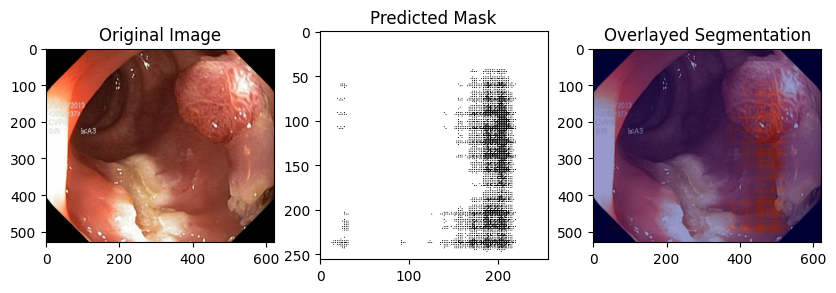

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def preprocess_image(image_path, img_size=(256, 256)):
    """ Load and preprocess a test image """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size) / 255.0  # Normalize to [0,1]
    return np.expand_dims(image, axis=0)  # Add batch dimension

def visualize_prediction(image_path, model, threshold=0.0008):
    """ Predict and visualize segmentation output """
    image = preprocess_image(image_path)

    # Predict mask
    predicted_mask = model.predict(image)[0, :, :, 0]  # Remove batch dimension

    # Apply thresholding to get a binary mask
    binary_mask = (predicted_mask > threshold).astype(np.uint8)

    # Resize to match original image size
    original = cv2.imread(image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    binary_mask_resized = cv2.resize(binary_mask, (original.shape[1], original.shape[0]))

    # Apply colormap
    colored_mask = cv2.applyColorMap(binary_mask_resized * 255, cv2.COLORMAP_JET)

    # Overlay mask on image
    overlayed = cv2.addWeighted(original, 0.6, colored_mask, 0.4, 0)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original)

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(binary_mask, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Overlayed Segmentation")
    plt.imshow(overlayed)

    plt.show()

# Example usage:
test_image_path = "/content/Kvasir-SEG/images/cju13fwthn9mq0835gacxgy01.jpg"
visualize_prediction(test_image_path, pranet_model)


In [ ]:
print(f"Min: {predicted_mask.min()}, Max: {predicted_mask.max()}")


NameError: name 'predicted_mask' is not defined

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/Kvasir-SEG.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
f4

flatten = tf.kears.layers.Flatten()(f4)

# turns into 1 d array

#[1,0.9,0.8,9,0.6]




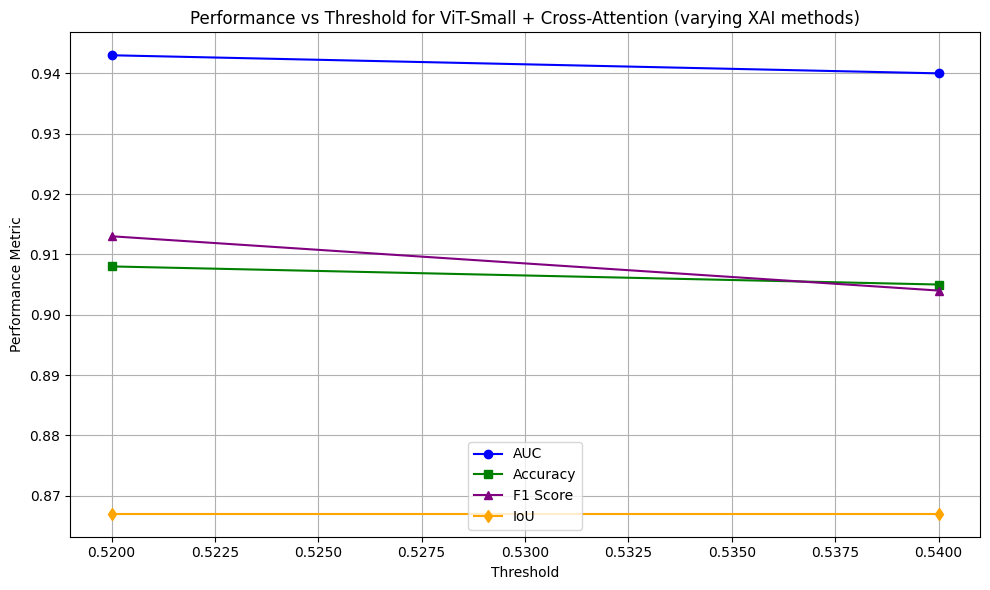

In [ ]:
import matplotlib.pyplot as plt

# Data
x = [0.54, 0.52]
auc = [0.94, 0.943]
acc = [0.905, 0.908]
f1 = [0.904, 0.913]
iou = [0.867, 0.867]

plt.figure(figsize=(10, 6))
plt.plot(x, auc, 'o-', label='AUC', color='blue')
plt.plot(x, acc, 's-', label='Accuracy', color='green')
plt.plot(x, f1, '^-', label='F1 Score', color='purple')
plt.plot(x, iou, 'd-', label='IoU', color='orange')

plt.xlabel("Threshold")
plt.ylabel("Performance Metric")
plt.title("Performance vs Threshold for ViT-Small + Cross-Attention (varying XAI methods)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



'''
X axis - threshold
Y axis - performance matric

1. Fix the best backbone and best attention, varying the different explainable methods
[make a colorful graph with suitable legends]

2. Fix the backbone, the threshold and the attention, vary the XAI and represent it visually [this is the main goal]

''''

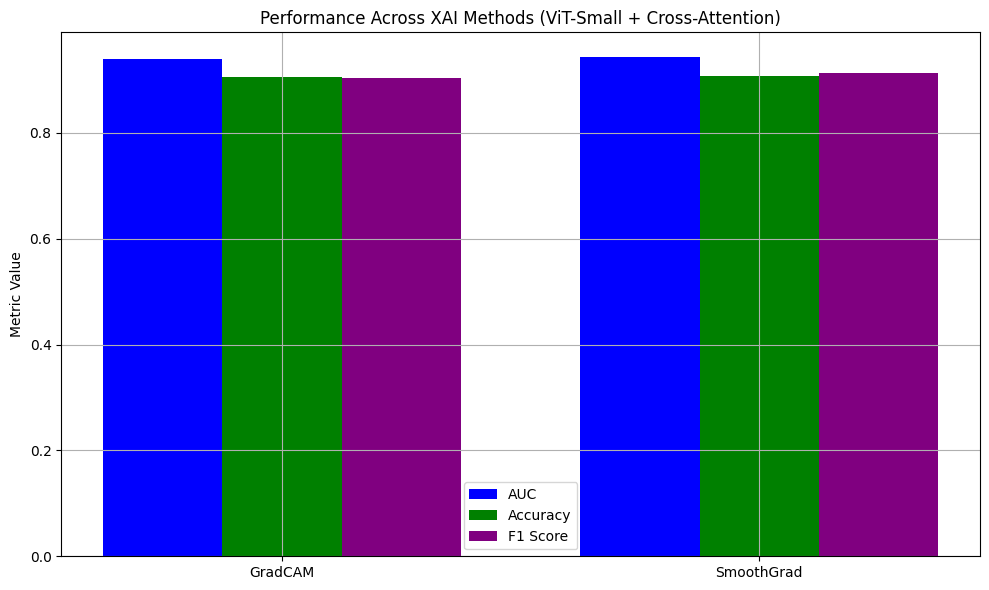

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
methods = ["GradCAM", "SmoothGrad"]
auc = [0.94, 0.943]
acc = [0.905, 0.908]
f1 = [0.904, 0.913]

x = np.arange(len(methods))
bar_width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, auc, width=bar_width, label='AUC', color='blue')
plt.bar(x, acc, width=bar_width, label='Accuracy', color='green')
plt.bar(x + bar_width, f1, width=bar_width, label='F1 Score', color='purple')

plt.xticks(x, methods)
plt.ylabel("Metric Value")
plt.title("Performance Across XAI Methods (ViT-Small + Cross-Attention)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


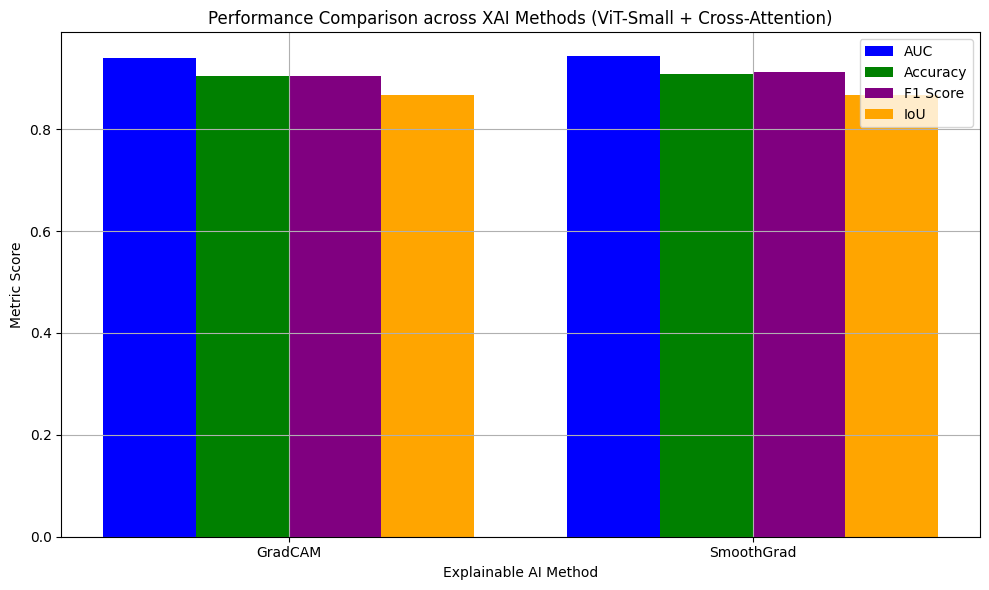

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample Data: Add more XAI methods as you evaluate them
xai_methods = ["GradCAM", "SmoothGrad"]
auc_scores = [0.940, 0.943]
accuracy_scores = [0.905, 0.908]
f1_scores = [0.904, 0.913]
iou_scores = [0.867, 0.867]

x = np.arange(len(xai_methods))
bar_width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*bar_width, auc_scores, width=bar_width, label='AUC', color='blue')
plt.bar(x - 0.5*bar_width, accuracy_scores, width=bar_width, label='Accuracy', color='green')
plt.bar(x + 0.5*bar_width, f1_scores, width=bar_width, label='F1 Score', color='purple')
plt.bar(x + 1.5*bar_width, iou_scores, width=bar_width, label='IoU', color='orange')

plt.xticks(x, xai_methods)
plt.xlabel("Explainable AI Method")
plt.ylabel("Metric Score")
plt.title("Performance Comparison across XAI Methods (ViT-Small + Cross-Attention)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
